In [11]:
# Initial imports qqqqqqqqq
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
%matplotlib inline

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

In [12]:
#sentiment_url = 'https://www.cnbc.com/markets/?='
sentiment_url = 'https://finviz.com/quote.ashx?t='

#tickers = ['AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','JPM','JNJ']
tickers = ['FB']

news_tables = {}
for ticker in tickers:
    url = sentiment_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [13]:
parsed_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
df['date'] = pd.to_datetime(df.date).dt.date
df

,ticker,date,time,title
0,FB,2021-05-13,02:22PM,Teens and social media: 'Unfollow some account...
1,FB,2021-05-13,02:08PM,Facebook (FB) Upgraded to Strong Buy: Here's Why
2,FB,2021-05-13,12:12PM,This Crypto Stock Was Thursday's Big Winner De...
3,FB,2021-05-13,12:05PM,Facebook ordered not to access WhatsApp user d...
4,FB,2021-05-13,11:51AM,How to Find Strong Buy Computer and Technology...
...,...,...,...,...
95,FB,2021-05-06,03:57PM,Facebook removes Ukraine political 'influence-...
96,FB,2021-05-06,03:49PM,Facebook removes Ukraine political 'influence-...
97,FB,2021-05-06,02:00PM,Facebook Removes Inauthentic Networks From Pal...
98,FB,2021-05-06,10:19AM,Klobuchar calls Trump 'the ultimate conveyor o...


In [14]:
nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
df['compound']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0     0.4404
1     0.5106
2     0.5859
3     0.0000
4     0.5106
       ...  
95    0.0000
96    0.0000
97    0.0000
98   -0.7096
99   -0.3818
Name: compound, Length: 100, dtype: float64

In [15]:
plt.figure(figsize=(10,8))
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
#mean_df = df.groupby(['ticker', 'date']).mean().unstack().dropna(axis='columns', thresh=7)
mean_df

compound                        ...                                 
date   2021-05-06 2021-05-07 2021-05-08  ... 2021-05-11 2021-05-12 2021-05-13
ticker                                   ...                                 
FB      -0.152844  -0.092129        0.0  ...   0.016983  -0.011976   0.260389

[1 rows x 8 columns]

<Figure size 720x576 with 0 Axes>

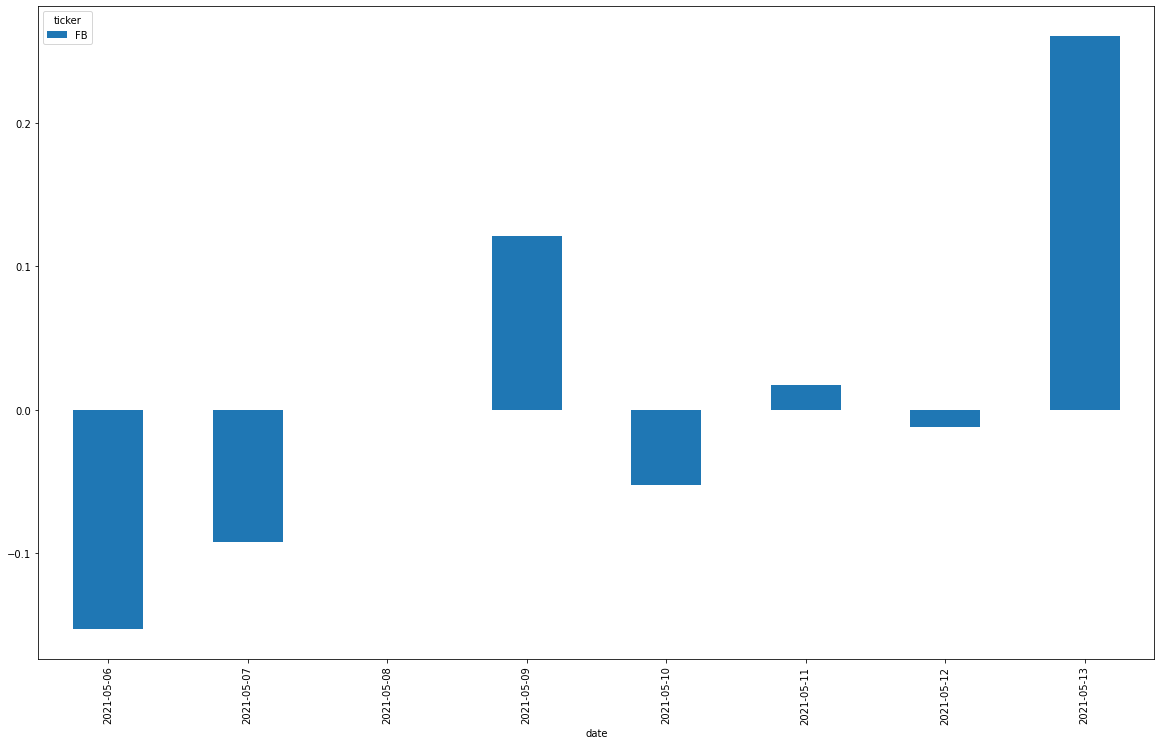

In [16]:
mean_df = mean_df.xs('compound', axis="columns").transpose()
mean_df.plot(kind='bar', figsize=(20, 12))
plt.show()

In [17]:
df2 =(df.groupby(['ticker', 'date']).mean())
df2

compound
ticker date                
FB     2021-05-06 -0.152844
       2021-05-07 -0.092129
       2021-05-08  0.000000
       2021-05-09  0.121150
       2021-05-10 -0.052336
       2021-05-11  0.016983
       2021-05-12 -0.011976
       2021-05-13  0.260389

In [18]:
def score(row):
    if row['compound'] > 0.05:
        signal = 1
    elif row['compound'] < -0.05:
        signal = -1
    else:
        signal = 0     
    return signal


df2['Signal'] = df2.apply(score, axis=1)
df2['Action'] = ["Buy" if x == 1 else "Sell" if x== -1 else "Hold" for x in df2['Signal']] 
df2

compound  Signal Action
ticker date                               
FB     2021-05-06 -0.152844      -1   Sell
       2021-05-07 -0.092129      -1   Sell
       2021-05-08  0.000000       0   Hold
       2021-05-09  0.121150       1    Buy
       2021-05-10 -0.052336      -1   Sell
       2021-05-11  0.016983       0   Hold
       2021-05-12 -0.011976       0   Hold
       2021-05-13  0.260389       1    Buy

In [ ]:
#df2.to_csv('signal_action.csv')